# EDA Notebook the first 

This is the intial eda notebook that I worked on when I was scraping the information prior to shifting directions and working on the kaggel dataset.

## Import control

The imports have been broken up as to when they are used and in what segment of our exploratory analysis. 

In [1]:
#The basics really
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.options.display.max_colwidth = 800
import os
import re, io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from itertools import chain



#Sentiment analysis
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()


#Sklearn vectorization
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#wordclouds
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator




#spAcey Scatterplot
import scattertext as st
from pprint import pprint
from scipy.stats import rankdata, hmean, norm
import spacy
import pkgutil, json, urllib
from urllib.request import urlopen
from IPython.display import IFrame
from IPython.core.display import display, HTML
from scattertext import CorpusFromPandas, produce_scattertext_explorer

#play with plottly
import plotly.express as px



## Bringing in the files from the directory

The files in the directory are marked by artist and song. Unfortunetly, the api has decided that I am an enemy of the state and has banished me for violation of the terms of service. However with some adjustments I can go back on there to acquire more material. In the future this project would benefit the acquistion of song names, albulm picture and other materials that seem to constrained by the provider. 

Intially this code ran an error:
"UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 2907500: character maps to `'<undefined>'" 
This simply means that the encoding has to be added to UTF-8.

The loop breaks out what we need: the file name and the text is then neatly settled in our dataframe. 

In [2]:
#https://stackoverflow.com/questions/33912773/python-read-txt-files-into-a-dataframe/33912971
#original code uses chdir which means Change directories no need changed to list to get all my files
file_names = os.listdir('./text/')
# Create Dictionary for File Name and Text
file_name_and_text = {}
for file in file_names:
    #UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 2907500: character maps to `<undefined> 
    #This means you need to change to a UTF- encoding`  
    with open('./text/' + file, "r", encoding="utf8") as target_file:
    #This reads everything from the directory and aliases it as the the target file 
         file_name_and_text[file] = target_file.read()
df = (pd.DataFrame.from_dict(file_name_and_text, orient='index')
             .reset_index().rename(index = str, columns = {'index': 'file_name', 0: 'text'}))

We will essentially build from these two columns. Our meterics and analyis will revolve around these two sets of information

In [3]:
df.sample(2)

,file_name,text
2,lyrics_2pac_ambitionzazaridah.txt,"[Intro]\nI won't deny it, I'm a straight ridah\nYou don't wanna fuck with me\nGot the police bustin' at me\nBut they can't do nothin' to a G\nLet's get ready to rumble!\nNow, you know how we do it, like a G\nWhat really go on in the mind of a nigga\nThat get down for theirs\nConstantly, money over bitches\nNot bitches over money\nStay on your grind, nigga\nMy ambitions as a ridah\nMy ambitions as a ridah\n\n[Verse 1]\nSo many battlefield scars while driven in plush cars\nThis life as a rap star is nothin' without guard\nWas born rough and rugged, addressin' the mass public\nMy attitude was ""fuck it,"" 'cause motherfuckers love it\nTo be a soldier, must maintain composure at ease\nThough life is complicated, only what you make it to be\nUh, and my ambitions as a ridah\nTo catch her while..."
38,lyrics_missyelliott_therainsupadupafly.txt,"[Intro: Missy Elliott & Timbaland]\n[*Yawning*]\nRun the track\n\n[Chorus: Missy Elliott & Ann Peebles]\nMe I'm super fly, super dupa fly\n(I can't stand the rain) Supa dupa fly\nMe I'm super fly, (against my window) super dupa fly\n(I can't stand the rain) supa dupa fly\nMe I'm super fly, (against my window) super dupa fly\n(I can't stand the rain) supa dupa fly\nMe I'm super fly, (against my window)\n\n[Verse 1: Missy Elliott]\nWhen the rain hits my window\nI take and *cough* me some indo\nMe and Timbaland, ooh, we sang a jangle\nWe so tight that you get our styles tangled\nSway on dosie-do like you loco\nCan we get kinky tonight?\nLike Coko, so-so\nYou don't wanna play with my Yo-Yo\nI smoke my hydro on the D-low (D-D-D-D-D-low)\n\n[Hook: Ann Peebles]\nI can't stand the rain against..."


The text files are filled with embedded markup, carriage returns and a copius amount of junk that would keep us scrubbing data.

Our process will do the following:

    1. Create the headers accordingly
    
    2. Fix any catagorical that is damaged along the way
    
    3. Mark embedded discription info such as hooks, produced by and not essentially lyrical information
    
    4. Purge empty and filler details out of the folds of the lyrics
    
    5. Use a lambda function using the [tags] to split the rows and create song fragments catgorized by the artist
    
    6. remove tabs, carriage returns and new lines, also elimination of everything but alpha charecters
    
    7. Using numpy nans, dropna's and drop duplicates to have the cleanest unique corpus. 


In [4]:
df['file_name']=df.file_name.str.lstrip('lyrics_')
#get the lyrics off take the string and make a column
df['artist'] = [x.split('_')[0] for x in df['file_name']]
#get the underscore off and make column for the performer
df['song'] = [x.split('_')[1] for x in df['file_name']]
#get the song as well in the other eda there is no song
df.song.replace('.txt', ' ', regex=True, inplace=True)
#clean up the text
df.drop(columns='file_name',inplace=True)
#get rid of it now
df.artist.replace('ardi', 'cardi', regex=True, inplace=True)
#fix the C in Cardi

In [5]:
df.reindex(['artist', 'song','text'], axis="columns").head(2)
#set index to the artist

,artist,song,text
0,2pac,2ofamerikazmostwanted,"[Intro: 2Pac & Snoop Doggy Dogg]\nUp out of there\nAin't nothin' but a gangsta party\nEh, light that up, Snoop! Why you actin' like that?\nAhh shit, you done fucked up now\n(Ain't nothin' but a gangsta party)\nYou done put two of America's most wanted\nIn the same motherfuckin' place at the same motherfuckin' time?\n(Ain't nothin' but a gangsta party)\nHa, ha, ha, ha, y'all niggas about to feel this\n(Ain't nothin' but a gangsta party)\nBreak out the champagne glasses and the motherfuckin' condoms\nHave one on us, a'ight?\n(Ain't nothin' but a gangsta party)\nA toast to the gangsters\n\n[Verse 1: 2Pac]\nPicture perfect, I paint a perfect picture\nBomb the hoochies with precision, my intention's to get richer\nWith the S-N double-O-P, Dogg, my fuckin' homie\nYou's a cold-ass nigga on th..."
1,2pac,alleyezonme,"[Intro: 2Pac]\nBig Syke, 'Nook, Paint, Bogart, Big Serge (yeah)\nY'all know how this shit go (you know)\nAll eyes on me\nMotherfuckin' OG\nRoll up in the club and shit, is that right?\nAll eyes on me\nAll eyes on me\nBut you know what?\n\n[Verse 1: 2Pac]\nI bet you got it twisted, you don't know who to trust\nSo many player-hatin' niggas tryna sound like us\nSay they ready for the funk, but I don't think they knowin'\nStraight to the depths of Hell is where them cowards goin'\nWell, are you still down? Nigga, holla when you see me\nAnd let these devils be sorry for the day they finally freed me\nI got a caravan of niggas every time we ride\nHittin' motherfuckers up when we pass by\nUntil I die, live the life of a boss player, 'cause even when I'm high\nFuck with me and get crossed late..."


Done:
    
~~1. Create the headers accordingly~~

We broke up the file name to provide an index and secondary index for the material. 

~~2. Fix any catagorical that is damaged along the way~~

The artist Cardi B lost the "C" in the start of the string we fixed that manually. I spent several minutes trying to figure out why and honestly I am not sure where the C went. 

In [6]:
#Code copuld be consolidated at a later time 
df['text'] = df.text.str.replace(r'Verse: ','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 1:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 1','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 2:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 2:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 3:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 3','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 4:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 4','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 5:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 5','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 6:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Verse 6','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Skit:','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Skit','XTFOZ',regex=True)
df['text'] = df.text.str.replace(r'Chorus:','',regex=True)
df['text'] = df.text.str.replace(r'Chorus','',regex=True)
df['text'] = df.text.str.replace(r'Intro:','',regex=True)
df['text'] = df.text.str.replace(r'Outro:','',regex=True)
df['text'] = df.text.str.replace(r'Intro','',regex=True)
df['text'] = df.text.str.replace(r'Outro','',regex=True)
df['text'] = df.text.str.replace(r'Break','',regex=True)
df['text'] = df.text.str.replace(r'Bridge','',regex=True)
df['text'] = df.text.str.replace(r'Hook','',regex=True)
df['text'] = df.text.str.replace(r'  ',' ',regex=True)

In [7]:
df.sample(2)

,text,artist,song
36,"[ People in background chatting]\nYo, yo yo move out of the way\nWe got Missy Elliott coming through\nGirl that is Missy Elliott she lost a lot of weight\nGirl I heard she eats one cracker a day\nOh well I heard the bitch was married to Tim and started fucking with Trina\nI heard the bitch got hit with three zebras and a monkey\nI can't stand the bitch no way\n\n[XTFOZ Missy Elliott]\nWhen I walk up in the piece\nI ain't gotta even speak\nI'm a bad mamajama\nGoddammit motherfucker you ain't gotta like me\nHow you stuntin' these hoes\nNeed to talk what you know\nAnd stop talking bout who I'm sticking and licking\nJust mad it ain't yours\nI know ya'll po' ya'll broke\nYa'll job just hanging up clothes\nStep to me get burnt like toast\nMuthafuckas, adios amigos\nHalves halves wholes whole...",missyelliott,gossipfolks
15,"[ Cardi B & 21 Savage]\nBardi in a 'Rari, diamonds all over my body\n(30, you a fool for this one)\nShinin' all over my body\nBardi, put that lil' bitch on molly, Bardi!\nBitch on molly (Cheeze)\n21, diamonds all over my body\nFucked that bitch on molly (KSR)\nAsk him if I'm 'bout it\n\n[ Cardi B & 21 Savage]\nYour bitch wanna party with Cardi\nCartier Bardi in a 'Rari (21)\nDiamonds all over my body (Cardi)\nShinin' all over my body (My body)\nCardi got your bitch on molly\nBitch, you ain't gang, you lame\nBentley truck lane to lane, blow out the brain (21)\nI go insane, insane\nI drop a check on the chain, fuck up a check in the Flame\nCardi took your man, you upset, uh\nCardi got rich, they upset, yeah (From what?)\nCardi put the pussy on Offset (Say what?)\nCartier, Cardi B brain o...",cardib,bartiercardi


Done:

~~3. Mark embedded discription info such as hooks, produced by and not essentially lyrical information~~

We used the marker "XTFOZ" which essentially means nothing and is most likely nowhere in the corpus to be a place holder this means that we are not directly purging it from the document just yet. The reason being we need it be in tact for step number 5 so that we can effectively break the document in fragements.

~~4. Purge empty and filler details out of the folds of the lyrics~~

Similar to the above except these are the ones we can do without. So they can be eliminated. 

In [8]:
df=(df.set_index(['artist', 'song'])
   .apply(lambda x: x.str.split('\[(.*?)\]').explode())
    #breaks on the brackets
   .reset_index()) 
df['text'] = df.text.str.replace(r'Verse','',regex=True)
#any 'Verse' got to go

In [9]:
df.sample(10)

,artist,song,text
464,dmx,ruffrydersanthem,\n\n
611,dmx,xgongiveittoya,"\nCome on\nUh, uh, come on"
655,missyelliott,gossipfolks,
314,cardib,bodakyellow,
212,2pac,meagainsttheworld,2Pac & Puff Johnson
671,missyelliott,imbetter,"\nI'mma start it from the bottom\nShow you how to flip a dollar\nI got food in my dining room\nI'm better, I'm better, I'm better\nIt's another day, another chance\nI wake up, I wanna dance\nSo as long as I got my friends...\nI'm better, I'm better, I'm better\n\n"
343,cardib,wap,"\nWhores in this house\nThere's some whores in this house\nThere's some whores in this house\nThere's some whores in this house (Hol' up)\nI said certified freak, seven days a week\nWet-ass pussy, make that pullout game weak, woo (Ah)\n\n"
34,2pac,alleyezonme,XTFOZ Big Syke
254,2pac,runnindyingtolive,
112,2pac,hailmary,\n\n


In [10]:
df=(df.set_index(['artist', 'song'])
   .apply(lambda x: x.str.split('n\n\/').explode())
    # breaks on double line breaks 
   .reset_index()) 

In [11]:
df.sample(1)

,artist,song,text
566,dmx,wherethehoodat,2


In [12]:
df.replace("", np.nan, inplace=True)
df.replace('  ', np.nan, inplace=True)
df.replace('   ', np.nan, inplace=True)
#convert the empties to numpy nans

In [13]:
df=(df.set_index(['artist', 'song'])
   .apply(lambda x: x.str.split('n\/').explode())
   .reset_index()) 
#breaks on line breaks

Done:
    
~~5. Use a lambda function using the [tags] to split the rows and create song fragments catgorized by the artist~~

Lambda creates a new row each time it parses a [tag] this will help effectively organize each piece for analysis and comparison. 

In [14]:
df.shape

(751, 3)

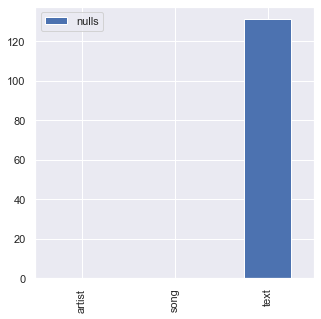

In [15]:
df.isnull().sum().plot(kind='bar',figsize=(5, 5), label="nulls");
plt.legend(loc="upper left");
#will visualize the Naned rows in text

In [16]:
df.dropna(inplace=True)
#remove them and proceed to seek dupes

In [17]:
df.drop_duplicates(inplace=True)
df.shape
#shed some rows

(476, 3)

In [18]:
df=df.drop(df[df.text.str.contains(r'XTFOZ')].index)
df.shape
#now terminate the placeholders shed more rows

(413, 3)

In [19]:
df.to_csv('./assets/spacey.csv')

In [20]:
df['text'] = df.text.str.replace(r"'",'',regex=True)
df['text'] = df.text.str.replace(r'[^a-zA-Z ]\s?',' ',regex=True)
#Since we are looking to tokenize words we will remove all special charecters and digits
df.replace('/(\r\n)+|\r+|\n+|\t+/', ' ', regex=True, inplace=True)
#kill the line breaks and tabs
df['text'] = df.text.str.replace(r'&',' ',regex=True)
df['text'] = df.text.str.replace(r'Pac','&',regex=True)
df['text'] = df.text.str.replace(r'Snoop Doggy Dogg','&',regex=True)
df['text'] = df.text.str.replace(r'The Notorious B I G','&',regex=True)
df['text'] = df.text.str.replace(r'Daz Dillinger','&',regex=True)
df['text'] = df.text.str.replace(r'Missy','&',regex=True)
df['text'] = df.text.str.replace(r'DMX','&',regex=True)
df=df.drop(df[df.text.str.contains(r'&')].index)
df=df.drop(df[df.text.str.contains(r'Produced by Pharrell')].index)
df=df.drop(df[df.text.str.contains(r'Produced by Swizz Beatz')].index)
df.shape

(335, 3)

In [21]:
df.replace("", np.nan, inplace=True)
df.replace('  ', np.nan, inplace=True)
df.replace('   ', np.nan, inplace=True)
df.replace('   ', np.nan, inplace=True)
df.replace('    ', np.nan, inplace=True)
df.replace('     ', np.nan, inplace=True)
df.dropna(inplace=True)
df.shape

(320, 3)

In [22]:
df.drop_duplicates(inplace=True)
df.shape

(314, 3)

~~6. remove tabs, carriage returns and new lines, also elimination of everything but alpha charecters~~

These are all gone.

~~7. Using numpy nans, dropna's and drop duplicates to have the cleanest unique corpus. ~~
One last time to be certain and to make sure we have a clean corpus.

In [23]:
df.sample(1)

,artist,song,text
531,dmx,wedontgiveafuck,There was always somethin there but I just couldnt touch it uh huh Wasnt somethin that would hurt me so a nigga said Fuck it uhh I let it slide laughed and joked let it ride true Now that you done killed it Im glad that it died AIGHT Its aight I know where you live Im just waitin uhh Til we knock on your front door and let you meet Satan cmon Thats what you get for hatin FUCK YOU FAGGOT WHAT I never did trust you faggot Ill bust you faggot WHAT What you done forgot about the streets is this uhh You do a grimy nigga like you do a grimy bitch AIGHT You just STOP fuckin wit him you got no more rap uh No more Yo whassup D No more dap uhh Be lucky if I dont spit in your face off of G P WHAT AND WHAT Bitch ass nigga you cant beat me woo Dont take it as a loss jus...


In [24]:
df.shape

(314, 3)

## Creating Lexicon Analysis

In [25]:
df['length']=df['text'].str.len()
df['number_words'] = df['text'].str.split().str.len()
#makes to new columns
df = df[df.length > 20]
#drops any thing with less than 20 chars
df.shape

(282, 5)

In [26]:
df["text"] = df["text"].str.lower()
df.sample(1)

,artist,song,text,length,number_words
340,cardib,up,look gotta play it safe huh no face no case hahaha,53,11


Now we have two additional columns that numerically analyze the amount verbage in a column and it's total length

It is time to define our target expletives 

In [27]:
number_explatives=(
#shit
df[df.text.str.contains(r'shit')].shape[0]+
df[df.text.str.contains(r'shits')].shape[0]+
df[df.text.str.contains(r'shitty')].shape[0]+
df[df.text.str.contains(r'bullshit')].shape[0]+
df[df.text.str.contains(r'shi')].shape[0]+
df[df.text.str.contains(r'shitty')].shape[0]+

#explicit_grouptwo    
df[df.text.str.contains(r'fuck')].shape[0]+
df[df.text.str.contains(r'fck')].shape[0]+
df[df.text.str.contains(r'fuckin')].shape[0]+                   
df[df.text.str.contains(r'fucking')].shape[0]+
df[df.text.str.contains(r'fawk')].shape[0]+
df[df.text.str.contains(r'fawkin')].shape[0]+
df[df.text.str.contains(r'fawks')].shape[0]+
df[df.text.str.contains(r'fawking')].shape[0]+
df[df.text.str.contains(r'fucked')].shape[0]+
df[df.text.str.contains(r'fucker')].shape[0]+
    
#bitch                   
df[df.text.str.contains(r'bitch')].shape[0]+
df[df.text.str.contains(r'bitches')].shape[0]+
df[df.text.str.contains(r'bich')].shape[0]+
df[df.text.str.contains(r'biches')].shape[0]+
df[df.text.str.contains(r'bitchez')].shape[0]+
df[df.text.str.contains(r'bitchz')].shape[0]+
df[df.text.str.contains(r'bitchass')].shape[0]+
df[df.text.str.contains(r'bitch-ass')].shape[0]+
    
#explicit_grouptwo 
df[df.text.str.contains(r'mother-fucker')].shape[0]+
df[df.text.str.contains(r'mother-fuckers')].shape[0]+
df[df.text.str.contains(r'motherfucker')].shape[0]+
df[df.text.str.contains(r'motherfuckers')].shape[0]+
df[df.text.str.contains(r'motherfucka')].shape[0]+
df[df.text.str.contains(r'motherfuckas')].shape[0]+
df[df.text.str.contains(r'muthafucka')].shape[0]+
df[df.text.str.contains(r'muthafuckas')].shape[0]+
df[df.text.str.contains(r'muthafuckaz')].shape[0]+
df[df.text.str.contains(r'motherfuckin')].shape[0]+
df[df.text.str.contains(r'muthafuckin')].shape[0]+
df[df.text.str.contains(r'mother fucker')].shape[0]+
df[df.text.str.contains(r'mother fuckers')].shape[0]+
df[df.text.str.contains(r'mother fucka')].shape[0]+
df[df.text.str.contains(r'mother fuckas')].shape[0]+
df[df.text.str.contains(r'mutha fucka')].shape[0]+
df[df.text.str.contains(r'mutha fuckas')].shape[0]+
df[df.text.str.contains(r'mutha fuckaz')].shape[0]+
df[df.text.str.contains(r'mother fuckin')].shape[0]+
df[df.text.str.contains(r'mutha fuckin')].shape[0]+
df[df.text.str.contains(r'mothafuckas')].shape[0]+
df[df.text.str.contains(r'mothafucka')].shape[0]+
    
    
#anatomy   
df[df.text.str.contains(r'dick')].shape[0]+
df[df.text.str.contains(r'dicks')].shape[0]+
df[df.text.str.contains(r'cock')].shape[0]+
df[df.text.str.contains(r'cocks')].shape[0]+
df[df.text.str.contains(r'pussy')].shape[0]+
df[df.text.str.contains(r'cunt')].shape[0]+
df[df.text.str.contains(r'cunts')].shape[0]+

#group_two    
df[df.text.str.contains(r'nigga')].shape[0]+
df[df.text.str.contains(r'niggas')].shape[0]+
df[df.text.str.contains(r'niggaz')].shape[0]+
df[df.text.str.contains(r'nikka')].shape[0]+    
df[df.text.str.contains(r'nikkas')].shape[0]+
df[df.text.str.contains(r'niggah')].shape[0]+
df[df.text.str.contains(r'niggahs')].shape[0]+
    
    
#profanity towards promiscuity    
df[df.text.str.contains(r'whore')].shape[0]+
df[df.text.str.contains(r'whores')].shape[0]+
df[df.text.str.contains(r'hoe')].shape[0]+
df[df.text.str.contains(r'hoes')].shape[0]+    
df[df.text.str.contains(r'hoez')].shape[0]+

#the buttocks
df[df.text.str.contains(r'assez')].shape[0]+
df[df.text.str.contains(r'asses')].shape[0]+
df[df.text.str.contains(r'ass')].shape[0]+
df[df.text.str.contains(r'asshole')].shape[0]+
df[df.text.str.contains(r'azz')].shape[0])

print(f"The number of {number_explatives} expletives and the total number of words in the corpus is {df.number_words.sum()}")

The number of 784 expletives and the total number of words in the corpus is 27235


In [28]:
percentage_of_corpus=round(number_explatives/df.number_words.sum(),4)

print(f"{percentage_of_corpus*100}% are expletives")

2.88% are expletives


In [29]:
#the complete list
expl_list=['shit','shits','shitty','bullshit','shi','fuck','fck','fuckin','fucking','fawk','fawkin','fawks',
           'fawking','bitch','bitches','bich','biches','bitchez','bitchz','bitchass','bitch-ass','mother-fucker',
           'mother-fuckers','motherfucker','motherfuckers','motherfucka','motherfuckas','muthafucka','muthafuckas',
           'muthafuckaz','motherfuckin','muthafuckin','mothafucka','mothafuckas','dick','dicks','cock','cocks','pussy','cunt','cunts','nigga',
           'niggas','niggaz','nikka','nikkas','niggah','niggahs','nigerina','whore','whores','hoe','hoes','hoez','assez','asses',
           'ass','asshole','azz']
# the first set of profanity used 
grp_one=['fucked','fucker','fuck','fck','fuckin','fucking','fawk','fawkin','fawks',
        'fawking','mother-fucker','mother-fuckers','mother fucker','mother fuckers','mother fucka',
         'mother fuckas','mutha fucka','mutha fuckas','mutha fuckaz','mother fuckin','mutha fuckin','mother fucker',
         'mother fuckers','mother fucka','mother fuckas','mutha fucka','mutha fuckas','mutha fuckaz','mother fuckin','mutha fuckin','mothafuckas','mothafucka']
# the second largest of profanity used
grp_two=['nigga','niggas','niggaz','nikka','nikkas','niggah','niggahs']

In [30]:
df.sample(2)

,artist,song,text,length,number_words
527,dmx,wedontgiveafuck,aiyyo x fuck them niggas them niggas aint your dogs better treat like some cats and shake they ass to the floor been seen the foul shit put the guns in em lil wannabe yous so why you run wit em you cant trust niggas no further than you can throw em you dont wanna murder the niggas then you blow em he usin yo style that make him yo child then he shouldnt make a move til he hear it from yo mouth we dont allow snakes runnin wit dogs tell them aint nuttin like a funeral thats gonna be yours double r and i aint here to start trouble god but if they wasnt your niggas i woulda been hit em hard niggas look like they phony what sound like they phony huh run around actin like motherfuckers homies we all make mistakes thats part of the breaks but you can still call the apes we bringin the du...,1018,204
470,dmx,ruffrydersanthem,niggas wanna try niggas wanna lie then niggas wonder why niggas wanna die all i know is pain all i feel is rain how can i maintain with that shit on my brain i resort to violence my niggas move in silence like you dont know what our style is new york niggas the wildest my niggas is with it you want it come and get it took it then we split it you fuckin right we did it what the fuck you gon do when we run up on you fuckin with the wrong crew dont know what we goin through ima have to show niggas how easily we blow niggas lemme find out theres some more niggas thats runnin with your niggas nothin we cant handle break it up and dismantle light it up like a candle just cause i cant stand you put my shit on tapes like you bustin grapes think you holdin weight then you havent met the apes,795,164


Now we will create the meterics that are focused on the existence of the expletives in the document. 

In [31]:
df['expl_bool']=df[['text']].apply(lambda x : x.str.contains('|'.join(expl_list)).sum(),axis=1)

In [32]:
df['total_expl'] = df['text'].str.count(r'\b|\b'.join(expl_list))
df['grp_1'] = df['text'].str.count(r'\b|\b'.join(grp_one))
df['grp_2'] = df['text'].str.count(r'\b|\b'.join(grp_two))

We can now visualize what we have:

Text(0.5, 1.0, 'Distribution of profanity')

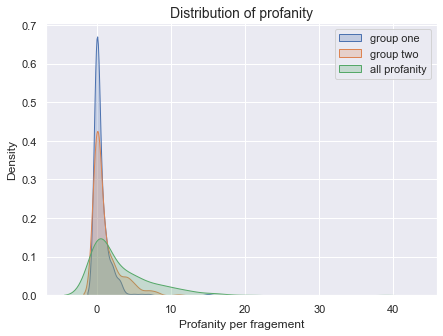

In [33]:

plt.figure(figsize=(7,5))
sns.kdeplot(df['grp_1'], label='group one', shade=True);
sns.kdeplot(df['grp_2'], label='group two', shade=True);
sns.kdeplot(df['total_expl'], label='all profanity', shade=True);
plt.legend(loc="upper right");
plt.xlabel('Profanity per fragement');
plt.title("Distribution of profanity", fontsize=14)

Text(0.5, 1.0, 'Word density per fragment')

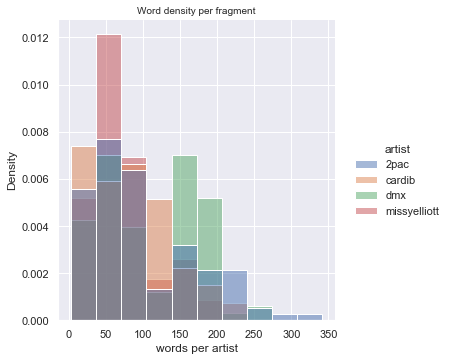

In [34]:
sns.displot(df, x="number_words", hue="artist", stat="density", common_norm=False);
plt.xlabel('words per artist');
plt.title("Word density per fragment", fontsize=10)

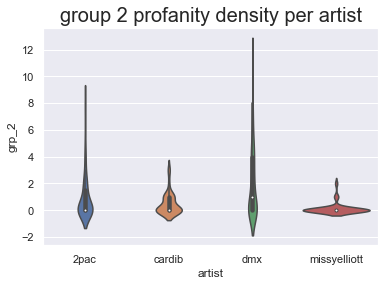

In [35]:
sns.violinplot(x='artist', y='grp_2', data=df);
plt.title("group 2 profanity density per artist", fontsize=20);

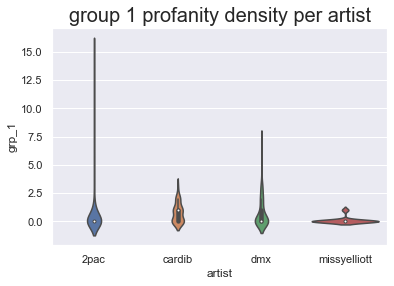

In [36]:
sns.violinplot(x='artist', y='grp_1', data=df);
plt.title("group 1 profanity density per artist", fontsize=20);

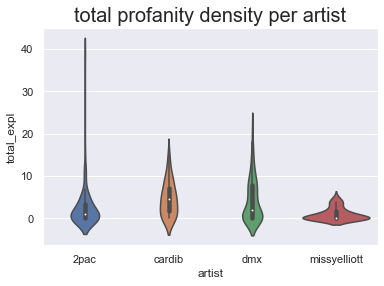

In [37]:
sns.violinplot(x='artist', y='total_expl', data=df)
plt.title("total profanity density per artist", fontsize=20);

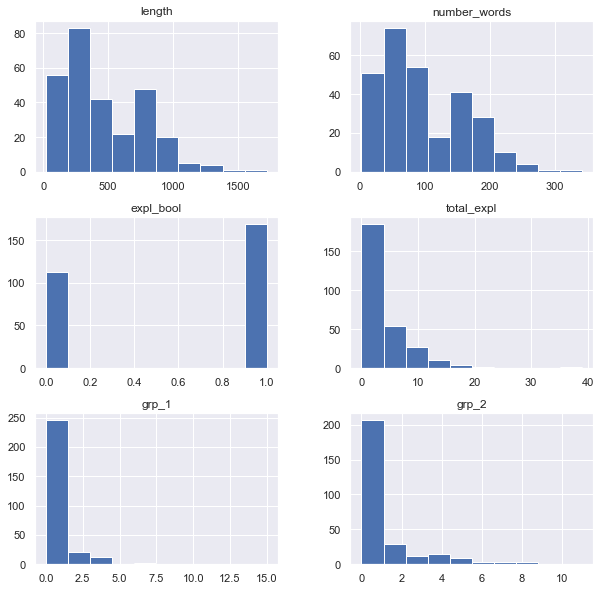

In [38]:
df.hist(figsize=(10,10));

In [39]:
def poles(text):
    try:
        return TextBlob(text).polarity
    except:
        return None
def subj(text):
    try:
        return TextBlob(text).subjectivity
    except:
        return None
#calls in each seperately for direct use alternatively you could get 
#it in a tuple but getting both values in the column is going to be annoying. 
    
    
    
df['tb_polarity'] = df['text'].apply(poles)
df['tb_subjectivity'] = df['text'].apply(subj)
#done Couldn't be any easier.
df.sample(2)

,artist,song,text,length,number_words,expl_bool,total_expl,grp_1,grp_2,tb_polarity,tb_subjectivity
622,dmx,xiscoming,you got yourself in a predicament that you cant get out of you already in some shit but its about to get hotter fuckin with a nigga like you runnin your mouth will have that same nigga like you gun in your mouth but wont be like the last time when you run in the house cause i aint knockin on the door im comin in the house and im gunnin for your spouse tryin to send the bitch back to her maker and if you got a daughter older than ima rape her take her on the livin room floor right there in front of you then ask you seriously whatchu wanna do frustratin isnt it wanna kill me but ima kill you now watch me fuck just a little while longer please will you this is revenge know that before you die and despite how much i hate to see a grown man cry ima make you suffer see your ass in hell m...,845,174,1,9,2,2,-0.146845,0.452738
302,cardib,becareful,the only man baby i adore i gave you everything whats mine is yours i want you to live your life of course but i hope you get what you dyin for be careful with me do you know what you doin whose feelings that youre hurtin and bruisin you gon gain the whole world but is it worth the girl that youre losin be careful with me yeah its not a threat its a warnin be careful with me yeah my heart is like a package with a fragile label on it be careful with me,456,97,0,0,0,0,0.026263,0.722222


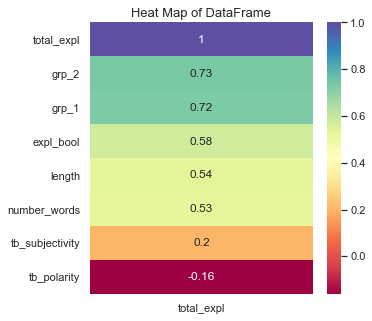

In [40]:
plt.figure(figsize=(5, 5))
plt.fontsize = 32
sns.heatmap(df.corr()[['total_expl']].sort_values('total_expl', ascending=False), 
            annot=True, cmap='Spectral', vmax=1);
plt.title("Heat Map of DataFrame", fontsize=13);

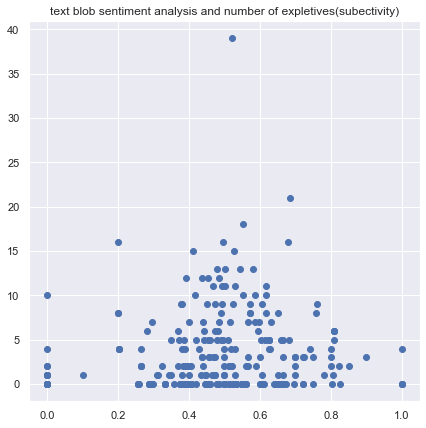

In [41]:
plt.figure(figsize=(7,7));
plt.scatter(x=df['tb_subjectivity'], y=df['total_expl']);
plt.title("text blob sentiment analysis and number of expletives(subectivity)", fontsize=12);

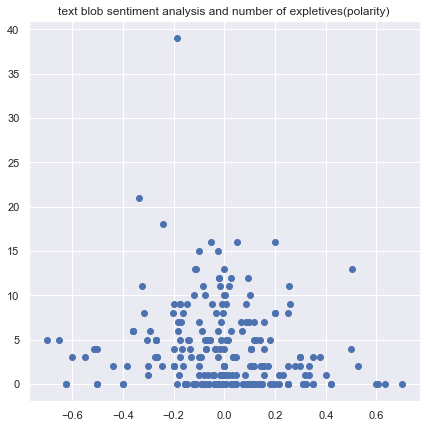

In [42]:
plt.figure(figsize=(7,7));
plt.scatter(x=df['tb_polarity'], y=df['total_expl']);
plt.title("text blob sentiment analysis and number of expletives(polarity)", fontsize=12);

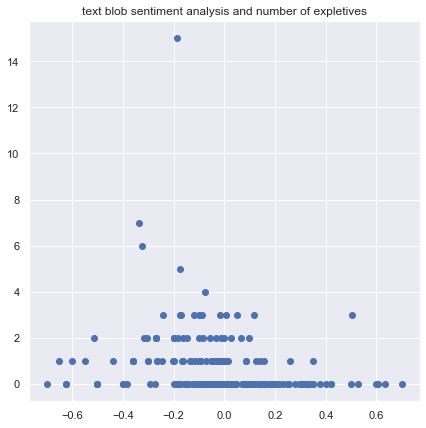

In [43]:
plt.figure(figsize=(7,7));
plt.scatter(x=df['tb_polarity'], y=df['grp_1']);
plt.title("text blob sentiment analysis and number of expletives", fontsize=12);

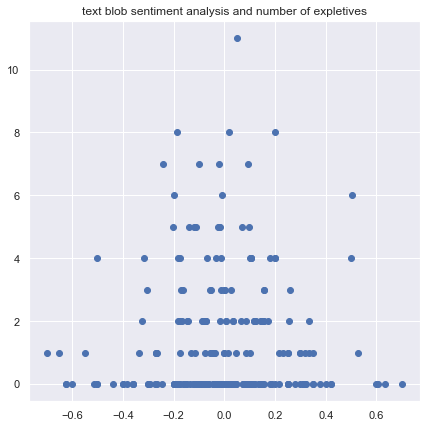

In [44]:
plt.figure(figsize=(7,7));
plt.scatter(x=df['tb_polarity'], y=df['grp_2']);
plt.title("text blob sentiment analysis and number of expletives", fontsize=12);

In [45]:
analyzer = SentimentIntensityAnalyzer()
df['vader'] = df['text'].apply(analyzer.polarity_scores)
df=pd.concat([df.drop(['vader'], axis=1), df['vader'].apply(pd.Series)], axis=1)

In [46]:
df.sample(1)

,artist,song,text,length,number_words,expl_bool,total_expl,grp_1,grp_2,tb_polarity,tb_subjectivity,neg,neu,pos,compound
27,2pac,alleyezonme,big syke nook paint bogart big serge yeah yall know how this shit go you know all eyes on me motherfuckin og roll up in the club and shit is that right all eyes on me all eyes on me but you know what,204,44,1,3,0,0,-0.022857,0.467143,0.104,0.863,0.034,-0.5147


In [47]:
df.rename(columns = {'neg':'vader_neg','neu':'vader_neu','pos':'vader_pos'}, inplace = True)

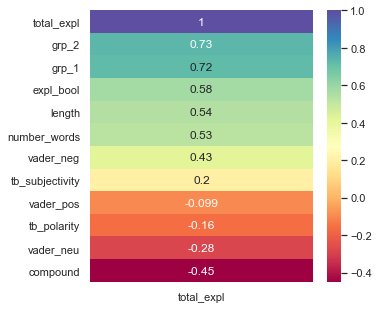

In [48]:
plt.figure(figsize=(5, 5))
plt.fontsize = 32
sns.heatmap(df.corr()[['total_expl']].sort_values('total_expl', ascending=False), 
            annot=True, cmap='Spectral', vmax=1);

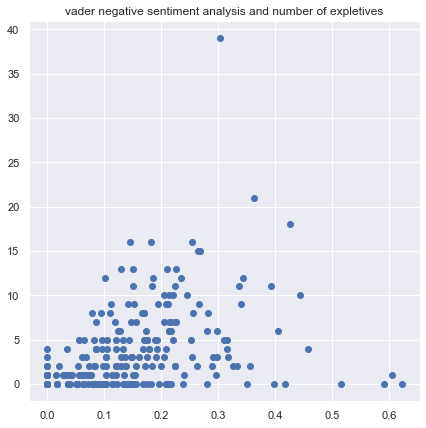

In [49]:
plt.figure(figsize=(7,7));
plt.scatter(x=df['vader_neg'], y=df['total_expl']);
plt.title("vader negative sentiment analysis and number of expletives", fontsize=12);

In [50]:
df.sample(1)

,artist,song,text,length,number_words,expl_bool,total_expl,grp_1,grp_2,tb_polarity,tb_subjectivity,vader_neg,vader_neu,vader_pos,compound
584,dmx,whowebe,they dont know who we be they dont know who we be they dont know who we be they dont know who we be,101,24,0,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0


In [51]:
df.sample(1)

,artist,song,text,length,number_words,expl_bool,total_expl,grp_1,grp_2,tb_polarity,tb_subjectivity,vader_neg,vader_neu,vader_pos,compound
188,2pac,lifegoeson,as i bail through the empty halls breath stinkin in my jaws ring ring ring quiet yall incomin call plus this my homie from high school he gettin by its time to bury another brother nobody cry life as a baller alcohol and booty calls we used to do em as adolescents do you recall raised as gs loced out and blazed the weed get on the roof lets get smoked out and blaze with me two in the morning and we still high assed out screamin thug til i die before i passed out but now that youre gone im in the zone thinkin i dont wanna die all alone but now you gone and all i got left are stinkin memories i love them niggas to death im drinkin hennessy while tryin to make it last i drank a fifth for that ass when you passed cause life goes on,742,152,1,2,0,1,0.102857,0.368571,0.124,0.819,0.057,-0.8618


In [52]:
artist_df=pd.get_dummies(df, columns=['artist'], prefix='', prefix_sep='')

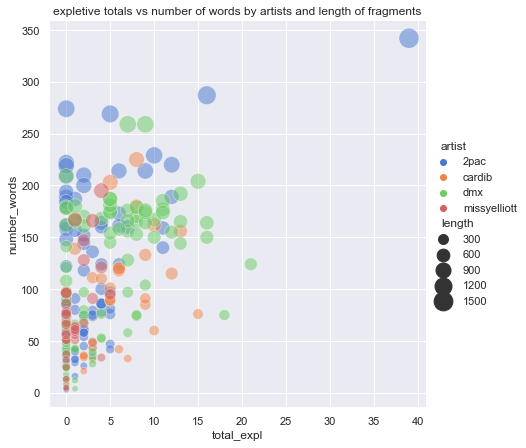

In [53]:
sns.relplot(x="total_expl", y="number_words", hue="artist", size="length",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df);
plt.title("expletive totals vs number of words by artists and length of fragments", fontsize=12);

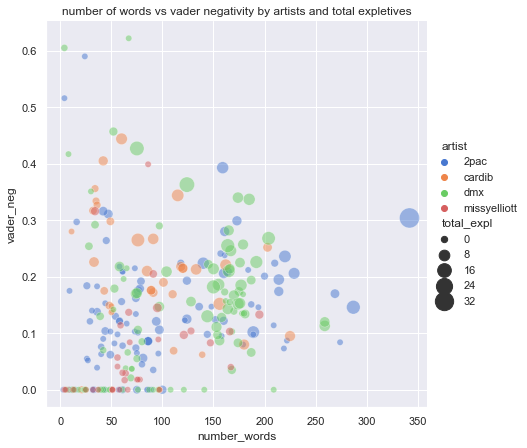

In [54]:
sns.relplot(x="number_words", y="vader_neg", hue="artist", size="total_expl",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df);
plt.title("number of words vs vader negativity by artists and total expletives", fontsize=12);

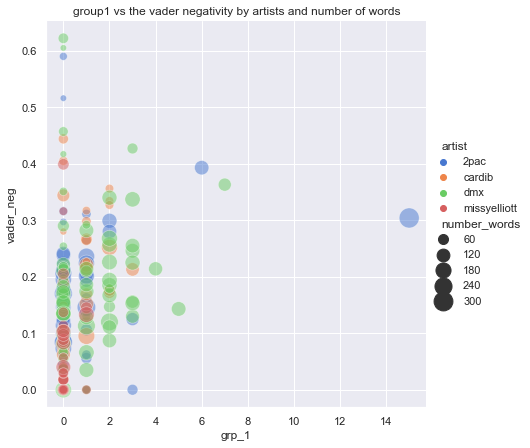

In [55]:
sns.relplot(x="grp_1", y="vader_neg", hue="artist", size="number_words",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=df);
plt.title("group1 vs the vader negativity by artists and number of words", fontsize=12);

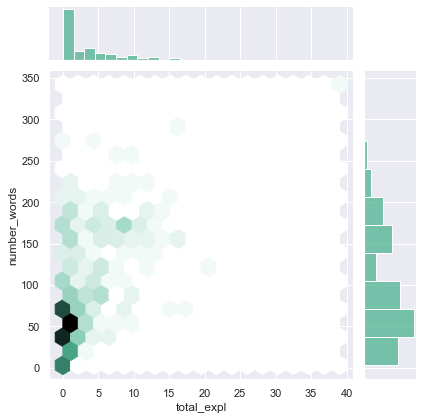

In [56]:
sns.jointplot(x=df['total_expl'], y=df['number_words'], kind="hex", color="#4CB391");

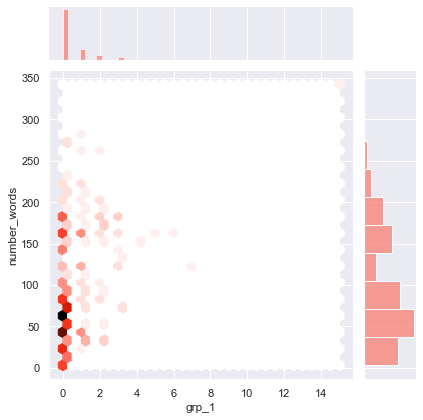

In [57]:
sns.jointplot(x=df['grp_1'], y=df['number_words'], kind="hex", color="salmon");

In [58]:
from scipy.stats import ttest_ind
ttest_ind(df.number_words,df.total_expl)


Ttest_indResult(statistic=23.954690966295697, pvalue=6.420215242593354e-88)

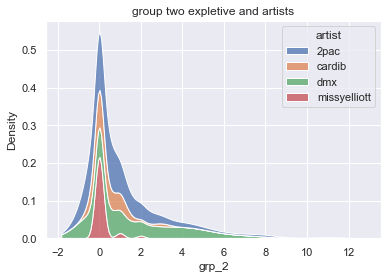

In [59]:
sns.kdeplot(data=df, x="grp_2", hue="artist", multiple="stack");
plt.title("group two expletive and artists", fontsize=12);

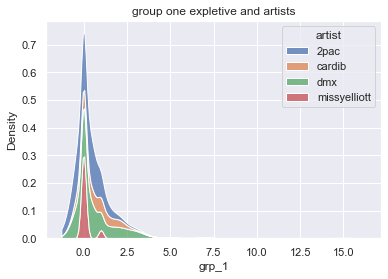

In [60]:
sns.kdeplot(data=df, x="grp_1", hue="artist", multiple="stack");
plt.title("group one expletive and artists", fontsize=12);

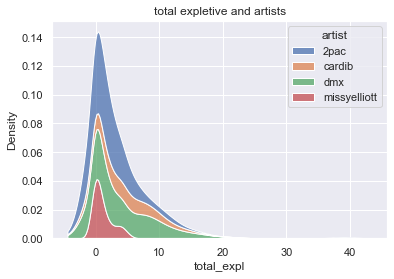

In [61]:
sns.kdeplot(data=df, x="total_expl", hue="artist", multiple="stack");
plt.title("total expletive and artists", fontsize=12);

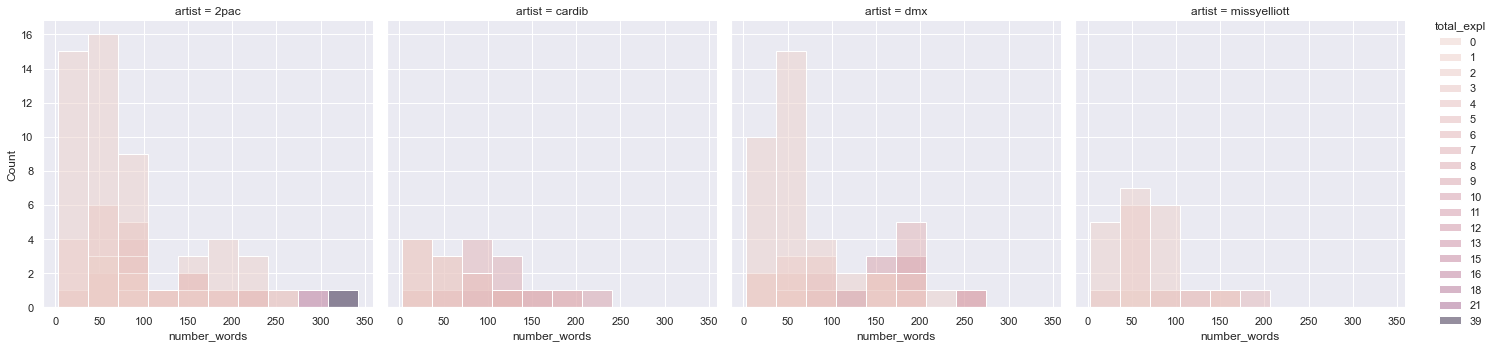

In [62]:
sns.displot(data=df, x="number_words", hue="total_expl", col="artist");

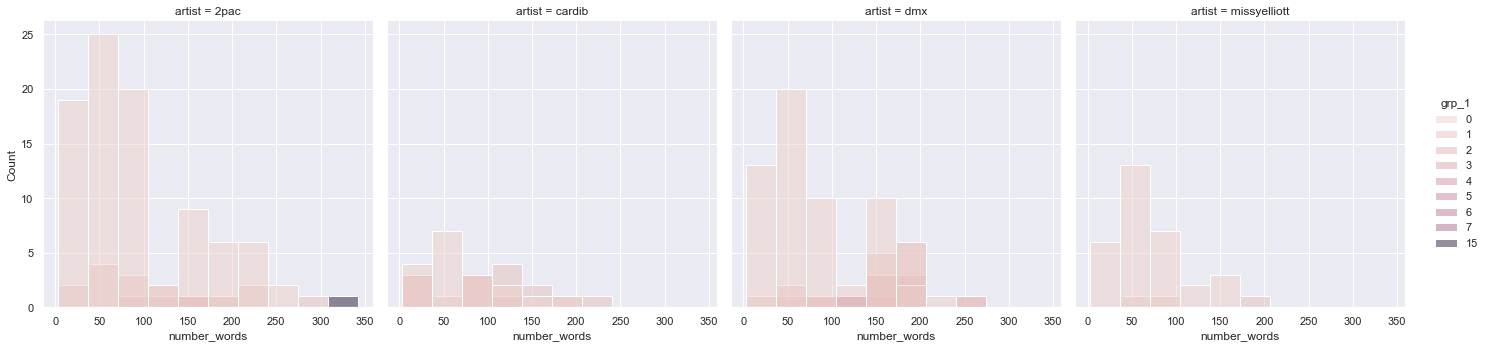

In [63]:
sns.displot(data=df, x="number_words", hue="grp_1", col="artist");

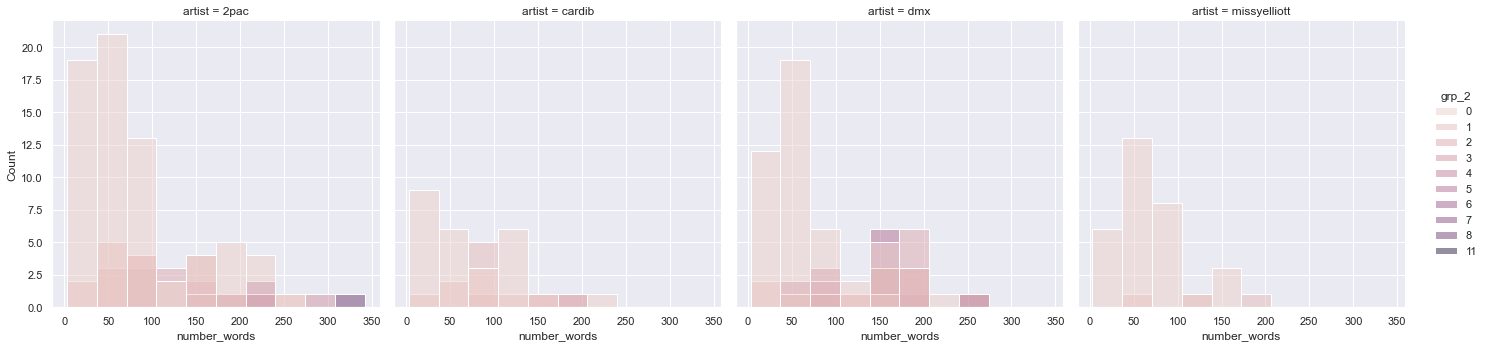

In [64]:
sns.displot(data=df, x="number_words", hue="grp_2", col="artist");

In [100]:
#fig1=px.scatter(df, x="vader_neg", y="total_expl", color="artist")
#fig1.show()
#fig1.write_html("./html/eda_results.html")
IFrame(src='./html/eda_results.html', width=700, height=500)

In [103]:
#fig1=px.scatter(df, x="total_expl", y="number_words", color="artist", size="grp_1", size_max=60)
#fig1.show()
#fig1.write_html("./html/eda_results2.html")
IFrame(src='./html/eda_results2.html', width=800, height=500)

In [109]:
#fig1= px.scatter_3d(df, x="number_words", y="length", z="total_expl", color="artist", size="total_expl", hover_name="total_expl",
                  #symbol="artist", color_discrete_map = {"Joly": "blue", "Bergeron": "green", "Coderre":"red"},width=800, height=800)
#fig1.show()
#fig1.write_html("./html/eda_results3.html")
IFrame(src='./html/eda_results3.html', width=1500, height=700)

In [113]:

#fig1=px.scatter(df, x="total_expl", y="number_words", color="artist", size="length", size_max=60,
          #hover_name="song", facet_col="artist", log_x=True)
#fig1.show()
#fig1.write_html("./html/eda_results5.html")
IFrame(src='./html/eda_results5.html', width=900, height=500)

In [116]:
#fig1=px.scatter(df, x="total_expl", y="length", color="vader_neg", trendline="ols", marginal_x="violin", marginal_y="box")
#fig1.show()
#fig1.write_html("./html/eda_results8.html")
IFrame(src='./html/eda_results8.html', width=900, height=500)

In [118]:
#fig1=px.scatter(df, x="vader_neg", y="number_words", color="total_expl", trendline="ols", marginal_x="violin", marginal_y="box")
#fig1.show()
#fig1.write_html("./html/eda_results12.html")
IFrame(src='./html/eda_results12.html', width=900, height=500)

In [71]:
extra_stop_words=['come','em','gon','im','know','dont','got','uh','like','yeah','aint','just','cause','want','thats','make','let','ya','yeah','yo','ay','wanna', 'huh','dmx','cardi','missy','2pac','kak','rak','pac']
stop_words = text.ENGLISH_STOP_WORDS.union(extra_stop_words)

## CountVectorizer

In [72]:
cvec = CountVectorizer(stop_words=stop_words)
X = df.text
cvec.fit(X)
text_cv = cvec.transform(df.text)
text_df = pd.DataFrame(text_cv.todense(), columns=cvec.get_feature_names())
text_df

,abandoned,abrupt,ac,accept,accident,accounts,ace,act,actin,acting,...,young,younger,youre,yous,youth,youve,yssim,yves,zee,zone
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
278,0,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
279,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
280,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
text_df.sum().sort_values(ascending = False).head(5)# provides the top results

nigga     159
niggas    153
shit       98
fuck       97
bitch      79
dtype: int64

In [74]:
text_df.sum().sort_values(ascending = False).tail(5)# provides the bottom results

mothafucka      1
mothafuckas     1
motherfucka     1
motherfuckas    1
abandoned       1
dtype: int64

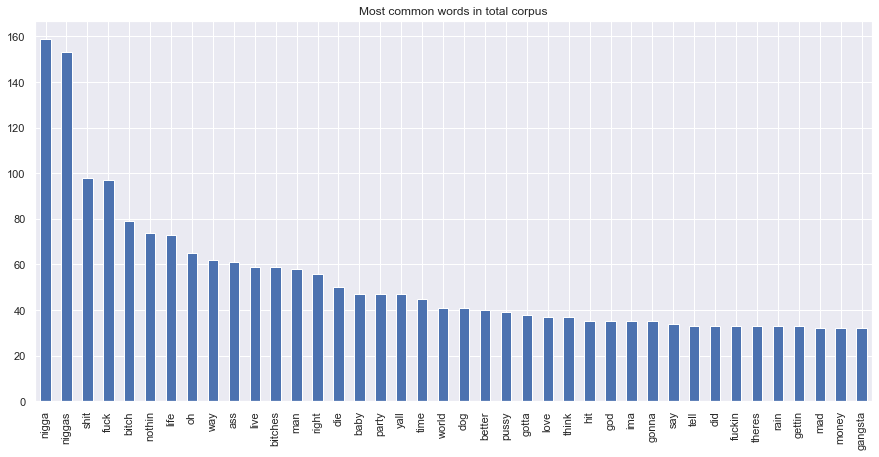

In [75]:
text_df.sum().sort_values(ascending = False).head(40).plot(kind='bar',figsize=(15,7));#visualizes it
plt.title("Most common words in total corpus", fontsize=12);

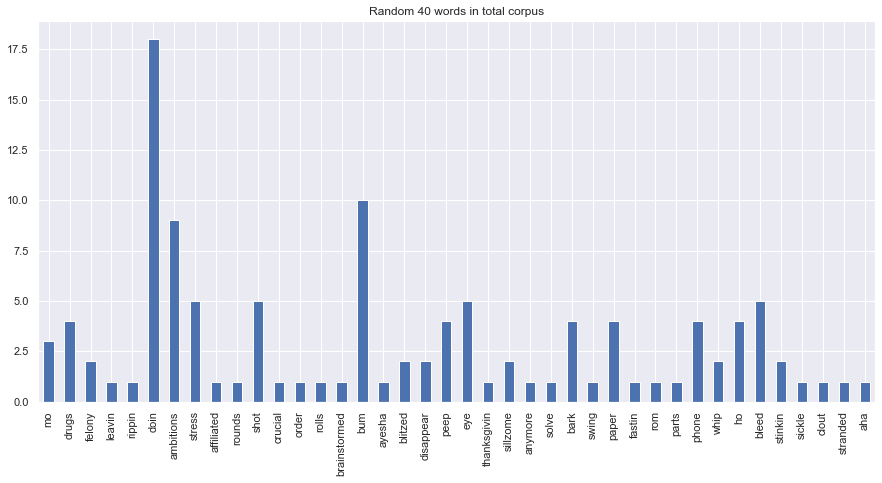

In [76]:
text_df.sum().sort_values(ascending = False).sample(40).plot(kind='bar',figsize=(15,7));#visualizes it
plt.title("Random 40 words in total corpus", fontsize=12);

In [77]:
mpc=text_df.sum().sort_values(ascending = False).head(40).to_dict()
#most popular
lpc=text_df.sum().sort_values(ascending = False).tail(40).to_dict()
#least popular

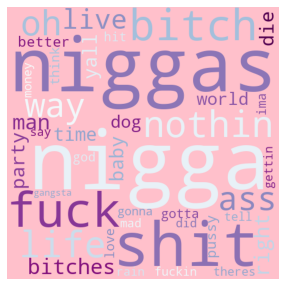

In [78]:
plt.figure( figsize=(5,5) )
plt.grid(False)
plt.axis('off')
#cleans up the word cloud
wc = WordCloud(colormap="BuPu",background_color="pink",width=500,height=500, max_words=40,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(mpc)
plt.imshow(wc);

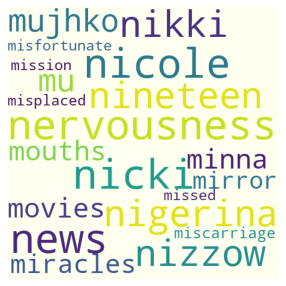

In [79]:
plt.figure( figsize=(5,5) )
plt.grid(False)
plt.axis('off')
#cleans up the word cloud
wc = WordCloud(background_color="ivory",width=500,height=500, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(lpc)
plt.imshow(wc);

# Tfidf

In [80]:
tfid = TfidfVectorizer(stop_words=stop_words)
X1 = df.text
tfid.fit(X)
text_tf = tfid.transform(df.text)
texttf_df = pd.DataFrame(text_tf.todense(), columns=tfid.get_feature_names())
texttf_df

,abandoned,abrupt,ac,accept,accident,accounts,ace,act,actin,acting,...,young,younger,youre,yous,youth,youve,yssim,yves,zee,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.095796,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.188236,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.160905,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,0.0,0.0,0.0,0.0,0.0,0.0,0.141773,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
278,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.222179,0.0,0.208242,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
279,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
280,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
texttf_df.sum().sort_values(ascending = False).head(5)# provides the top results

niggas    9.856415
nigga     9.744633
shit      7.171939
fuck      6.467930
bitch     6.104584
dtype: float64

In [82]:
texttf_df.sum().sort_values(ascending = False).tail(5)# provides the bottom results

felt            0.077238
millionaires    0.077238
quadruple       0.077238
ballers         0.055479
beatz           0.039150
dtype: float64

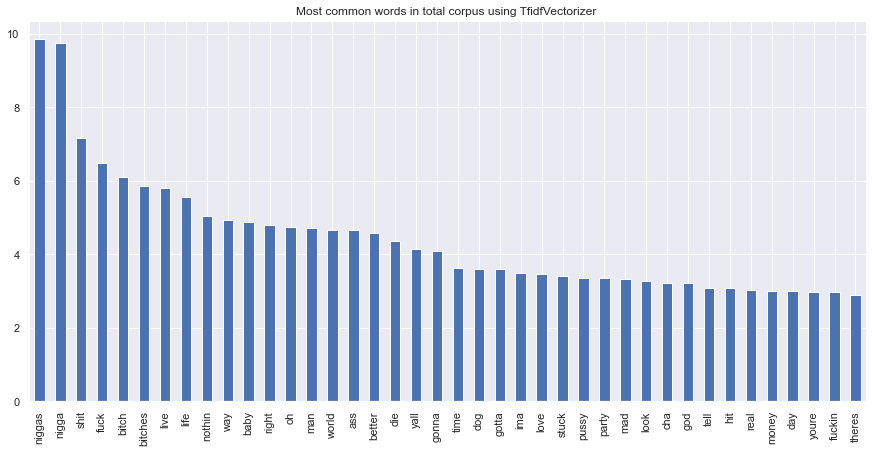

In [83]:
texttf_df.sum().sort_values(ascending = False).head(40).plot(kind='bar',figsize=(15,7));#visualizes it
plt.title("Most common words in total corpus using TfidfVectorizer ", fontsize=12);

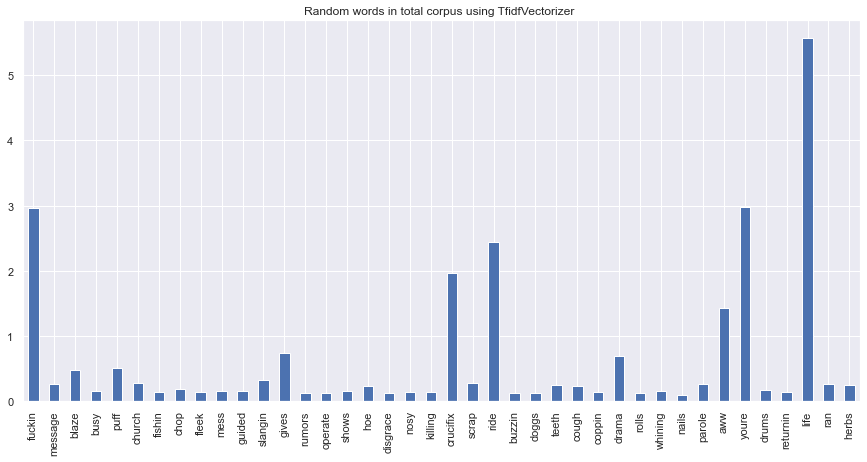

In [84]:
texttf_df.sum().sort_values(ascending = False).sample(40).plot(kind='bar',figsize=(15,7));#visualizes it
plt.title("Random words in total corpus using TfidfVectorizer ", fontsize=12);

In [85]:
mpc_tf=texttf_df.sum().sort_values(ascending = False).head(40).to_dict()

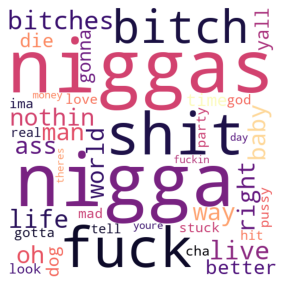

In [86]:
plt.figure( figsize=(5,5) )
plt.grid(False)
plt.axis('off')
#cleans up the word cloud
wc = WordCloud(colormap="magma",background_color="white",width=500,height=500, max_words=40,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(mpc_tf)
plt.imshow(wc);

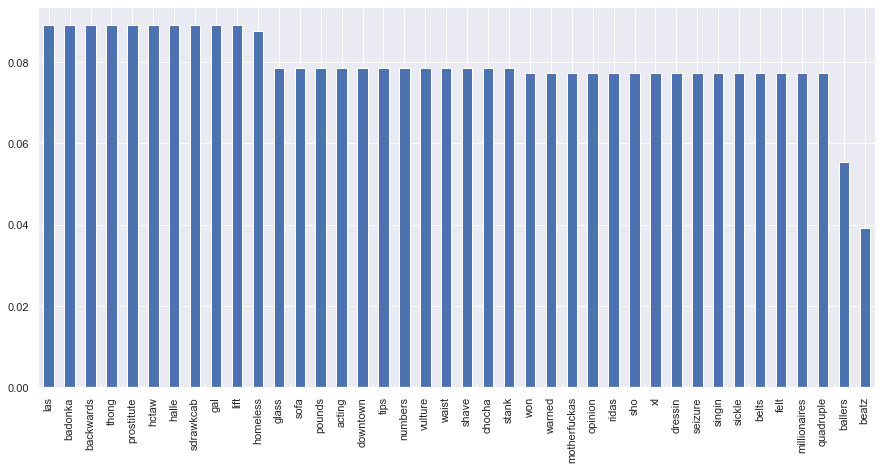

In [87]:
texttf_df.sum().sort_values(ascending = False).tail(40).plot(kind='bar',figsize=(15,7));#visualizes it

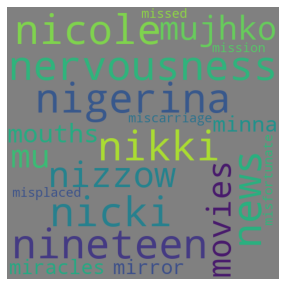

In [88]:
plt.figure( figsize=(5,5) )
plt.grid(False)
plt.axis('off')
#cleans up the word cloud
wc = WordCloud(background_color="grey",width=500,height=500, max_words=20,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(lpc)
plt.imshow(wc);

## Make clean word clouds 

In [89]:
clean = text_df.drop(columns=[col for col in text_df if col in expl_list])

In [90]:
clean_mpc=clean.sum().sort_values(ascending = False).head(40).to_dict()
#most popular
clean_lpc=clean.sum().sort_values(ascending = False).tail(40).to_dict()
#least popular

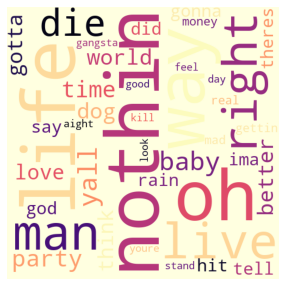

In [91]:
plt.figure( figsize=(5,5) )
plt.grid(False)
plt.axis('off')
#cleans up the word cloud
wc = WordCloud(colormap="magma",background_color="lightyellow",width=500,height=500, max_words=40,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(clean_mpc)
plt.imshow(wc);

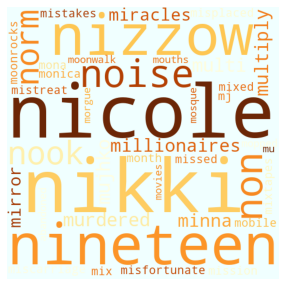

In [92]:
plt.figure( figsize=(5,5) )
plt.grid(False)
plt.axis('off')
#cleans up the word cloud
wc = WordCloud(colormap="YlOrBr",background_color="azure",width=500,height=500, max_words=40,relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(clean_lpc)
plt.imshow(wc);

In [93]:
df.to_csv('./assets/1sample.csv',index=False)